# Using your our own glacier inventory with OGGM

[The Randolph Glacier Inventory](https://www.glims.org/RGI/) is a key dataset to model glaciers at any scale: it includes outlines of the extent of each glacier in the world, an information that is critical in figuring out how much a particular glacier might contribute to rising sea level. These glacier outlines are the starting point of any simulation in OGGM. The RGI's latest version (v6), as well as v5, are provided and supported by OGGM (see the [documentation](https://oggm.readthedocs.io/en/latest/input-data.html#glacier-outlines-and-intersects)). However, there are [several issues](https://rgitools.readthedocs.io/en/latest/known-issues.html) in the RGI that might make you want to use your own corrected glacier outlines. 

This notebook describes how to feed OGGM with them. We will show you three case studies about how to give any geometry to OGGM and avoid errors of incompatibility between your shapefile and the model framework.

We have three case studies which should cover a number of applications:
1. [Dividing a glacier into smaller entities](#case1) (common case, useful for poorly outlined glaciers, which are in reality separate dynamical entities)
2. [Merging two glaciers together](#case2) (useful for tidewater glaciers in particular, not much elsewhere)
3. [Start from a completely independent inventory](#case3)

## TLDR;

If you want to use custom data to feed OGGM with, you should:
- **make a shapefile that resembles the RGI one: same attributes, and the glacier geometries should be in lon/lat projection**. The most important attribute is `geometry`, of course, but others are used by OGGM as well: refer to [the OGGM documentation](https://docs.oggm.org/en/latest/input-data.html#glacier-outlines-and-intersects) to decide which ones. The RGI documentation (found in the RGI directory after download) is useful as well!
- **compute and use a new [glacier interesects](https://rgitools.readthedocs.io/en/latest/tools.html#glacier-intersects) file**, or make sure you don't need one and disable this option in OGGM. 

## Structure of an RGI file

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
import os
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import inversion
cfg.initialize(logging_level='WARNING')

2021-02-03 13:50:28: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:50:28: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:50:28: oggm.cfg: Multiprocessing: using all available processors (N=8)


Let's read a file from the standard RGI:

In [3]:
utils.get_rgi_dir(version='61')

'/home/mowglie/disk/OGGM_INPUT/rgi/RGIV61'

In [4]:
sh = utils.get_rgi_region_file('11', version='61')
sh

'/home/mowglie/disk/OGGM_INPUT/rgi/RGIV61/11_rgi61_CentralEurope/11_rgi61_CentralEurope.shp'

Shapefiles are best read an manipulated with [geopandas](http://geopandas.org/) in python (see also our [working_with_rgi.ipynb](working_with_rgi.ipynb) tutorial):

In [5]:
gdf = gpd.read_file(sh)
gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-11.00001,G013599E47495N,20030799,20030999,13.5987,47.4949,11,1,0.122,2191,...,461,0,0,0,0,9,9,None,None,"POLYGON ((13.60035 47.49330, 13.59995 47.49332..."
1,RGI60-11.00002,G013614E47485N,20030799,20030999,13.6135,47.4845,11,1,2.292,2203,...,1853,0,0,0,0,9,9,None,None,"POLYGON ((13.60638 47.47578, 13.60599 47.47579..."
2,RGI60-11.00003,G013596E47484N,20030799,20030999,13.5960,47.4835,11,1,0.851,2280,...,1140,0,0,0,0,9,9,None,None,"POLYGON ((13.59765 47.47613, 13.59726 47.47614..."
3,RGI60-11.00004,G013583E47481N,20030799,20030999,13.5829,47.4807,11,1,0.053,2319,...,382,0,0,0,0,9,9,None,None,"POLYGON ((13.58283 47.47969, 13.58243 47.47971..."
4,RGI60-11.00005,G013603E47477N,20030799,20030999,13.6026,47.4774,11,1,0.057,2656,...,202,0,0,0,0,9,9,None,None,"POLYGON ((13.60076 47.47519, 13.60036 47.47521..."


An RGI file contains the actual glacier geometries, but also a number of attribute which are used by OGGM afterwards. Let's learn how to make our own file now. 

<a id='case1'></a>
## Case 1: dividing a glacier into smaller entities

A typical example of wrongly divided glacier is Hintereisferner, in Austria:

2021-02-03 13:50:33: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


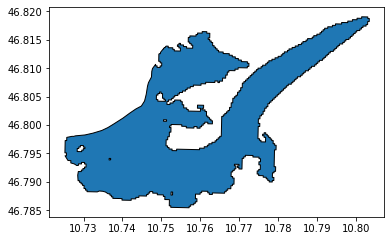

In [6]:
# OGGM set-up
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='rgi-case-1', reset=True)
cfg.PARAMS['border'] = 10

# Get the HEF geometry and plot it
gl = utils.get_rgi_glacier_entities(['RGI60-11.00897'])
gl.plot(edgecolor='k');

Obviously, the two smaller tongues used to flow in the main one but this is not the case anymore today. We need updated geometries.

### Make a new "RGI file"

There is no simple way to automate the process of finding these bad geometries, but we are [working on this](https://github.com/OGGM/partitioning) (don't hold your breath, this has been in development since a long time). Here we use a geometry that we prepared in QGis:

In [7]:
# We simulate the case where we only have the geometry, nothing else
divides = gpd.read_file(utils.get_demo_file('divides_alps.shp'))
divides = divides.loc[divides.RGIId == 'RGI50-11.00897'][['geometry']]
divides

,geometry
1,"POLYGON ((10.74505 46.80376, 10.74610 46.80293..."
93,"POLYGON ((10.74860 46.80493, 10.74717 46.80529..."
94,"POLYGON ((10.74602 46.80561, 10.74717 46.80529..."


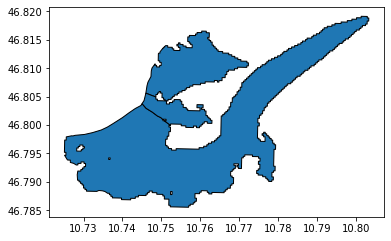

In [8]:
divides.plot(edgecolor='k');

Now we use the RGI entity as template - it's good to use the same attributes as the original RGI glacier, because most of them are already correct:

In [9]:
template = pd.concat([gl]*3, ignore_index=True)
template

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-11.00897,G010758E46800N,20030799,20030999,10.7584,46.8003,11,1,8.036,2430,...,71,7178,0,0,0,0,9,1,Hintereisferner,"POLYGON ((10.75085 46.81381, 10.75112 46.81397..."
1,RGI60-11.00897,G010758E46800N,20030799,20030999,10.7584,46.8003,11,1,8.036,2430,...,71,7178,0,0,0,0,9,1,Hintereisferner,"POLYGON ((10.75085 46.81381, 10.75112 46.81397..."
2,RGI60-11.00897,G010758E46800N,20030799,20030999,10.7584,46.8003,11,1,8.036,2430,...,71,7178,0,0,0,0,9,1,Hintereisferner,"POLYGON ((10.75085 46.81381, 10.75112 46.81397..."


We change the important ones:

In [10]:
# Attributes
template['RGIId'] = ['RGI60-11.00897_d01', 'RGI60-11.00897_d02', 'RGI60-11.00897_d03']
template['Name'] = ['Hintereisferner d01', 'Hintereisferner d02', 'Hintereisferner d03']
# Geometries
template['geometry'] = divides['geometry'].values
# Center point
for i, geom in template[['geometry']].iterrows():
    cenlon, cenlat = geom.geometry.centroid.xy
    template.loc[i, 'CenLon'] = cenlon
    template.loc[i, 'CenLat'] = cenlat
# This is important to properly georeference the file
import salem
template.crs = salem.wgs84.srs

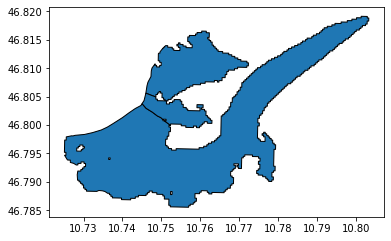

In [11]:
template.plot(edgecolor='k');

Save it: 

In [12]:
hef_new_shape_path = os.path.join(cfg.PATHS['working_dir'], 'hef_divided.shp')
template.to_file(hef_new_shape_path)

### Compute the intersects

Hintereisferner has a divide with another glacier as well! Let's find out which:

In [13]:
intersects_alps = gpd.read_file(utils.get_rgi_intersects_region_file('11'))
intersects_hef = intersects_alps.loc[(intersects_alps.RGIId_1 == 'RGI60-11.00897') | (intersects_alps.RGIId_2 == 'RGI60-11.00897')]
intersects_hef

,RGIId_1,RGIId_2,geometry
119,RGI60-11.00846,RGI60-11.00897,"LINESTRING (10.74826 46.81077, 10.74840 46.810..."
143,RGI60-11.00897,RGI60-11.00846,"LINESTRING (10.72557 46.79781, 10.72557 46.797..."


Ok, we can now create a file which has all the glaciers we need to compute the relevant intersects (note that we could also use the full standard RGI with just HEF replaced):

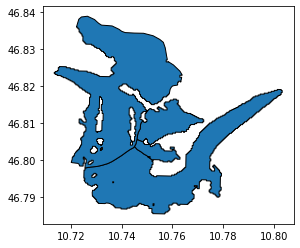

In [14]:
for_intersects = pd.concat([template, utils.get_rgi_glacier_entities(['RGI60-11.00846'])], ignore_index=True)
for_intersects.crs = salem.wgs84.srs
for_intersects.plot(edgecolor='k');

Good! Let's use [rgitools](https://rgitools.readthedocs.io) to compute the intersects for this new situation: 

In [15]:
from rgitools.funcs import compute_intersects
new_intersects = compute_intersects(for_intersects)

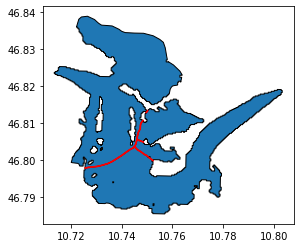

In [16]:
f, ax = plt.subplots()
for_intersects.plot(ax=ax, edgecolor='k');
new_intersects.plot(ax=ax, edgecolor='r');

Good! We can store our intersects to use them with OGGM afterwards:

In [17]:
hef_intersects_path = os.path.join(cfg.PATHS['working_dir'], 'hef_divided_intersects.shp')
new_intersects.to_file(hef_intersects_path)

### Finally: the OGGM run 

In [18]:
# This is important! We tell OGGM to recompute the glacier area for us
cfg.PARAMS['use_rgi_area'] = False
# This is the default anyway, but we set it here to be sure
cfg.PARAMS['use_intersects'] = True

# This is important!
cfg.set_intersects_db(hef_intersects_path)

# This is to avoid a download in the tutorial, you dont' need do this at home
cfg.PATHS['dem_file'] = utils.get_demo_file('hef_srtm.tif')

# This is important again - standard OGGM 
rgidf = gpd.read_file(hef_new_shape_path)
gdirs = workflow.init_glacier_directories(rgidf, reset=True, force=True)

PARAMS['use_rgi_area'] changed from `True` to `False`.
Execute entity task GlacierDirectory on 3 glaciers


In [19]:
workflow.execute_entity_task(tasks.define_glacier_region, gdirs);
workflow.execute_entity_task(tasks.glacier_masks, gdirs);
workflow.execute_entity_task(tasks.compute_centerlines, gdirs);
workflow.execute_entity_task(tasks.initialize_flowlines, gdirs);
workflow.execute_entity_task(tasks.catchment_area, gdirs);
workflow.execute_entity_task(tasks.catchment_width_geom, gdirs);
workflow.execute_entity_task(tasks.catchment_width_correction, gdirs);

Execute entity task define_glacier_region on 3 glaciers
Execute entity task glacier_masks on 3 glaciers
Execute entity task compute_centerlines on 3 glaciers
Execute entity task initialize_flowlines on 3 glaciers
Execute entity task catchment_area on 3 glaciers
Execute entity task catchment_width_geom on 3 glaciers
Execute entity task catchment_width_correction on 3 glaciers


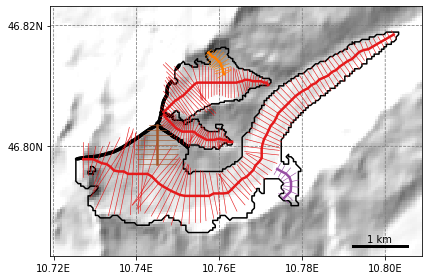

In [20]:
graphics.plot_catchment_width(gdirs, add_intersects=True, corrected=True)

It works!

**The intersects in OGGM are used for two main things:**
- when a grid-point glacier section touches an intersect, it will be attributed a rectangular bed (instead of a parabolic one)
- when interpolating the ice thickness to a 2D grid, the boundary condition thickness=0 at the glacier outline is removed where there are intersects

**We recommend to use intersects for your runs as well.**

<a id='case2'></a>
## Case 2: merging glaciers 

Sometimes, you may want to *merge* glaciers together. This case is less frequent than Case 1, but might be useful for calving glaciers, which are sometimes divided in the RGI.

### Original RGI outlines

We use a case study for two marine-terminating glaciers in Alaska that have to be merged into a single outline in order to model a correct calving flux for these glaciers (following the methods described in
[Recinos, et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/)). The resulting shapefile is a new one that needs to be adapted in order for OGGM to run.

We will study the Sawyer Glacier (`RGI60-01.03890`) that is actually connected via the calving front with this other entity (`RGI60-01.23664`). Visit this [link](https://glacierchange.wordpress.com/2011/03/16/saywer-glacier-alaska-retreat/) to learn more about the retreat of the Sawyer Glacier and see images illustrating this connection.

In [21]:
gl = utils.get_rgi_glacier_entities(['RGI60-01.03890', 'RGI60-01.23664'])

Here OGGM downloaded the outlines for both glaciers. If we plot them together, we can see that both glaciers drain into the same fjord. See the google map below:

2021-02-03 13:51:37: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:51:37: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:51:37: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 13:51:37: oggm.cfg: PARAMS['border'] changed from `20` to `10`.
2021-02-03 13:51:37: oggm.workflow: init_glacier_directories from prepro level 3 on 2 glaciers.
2021-02-03 13:51:37: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers


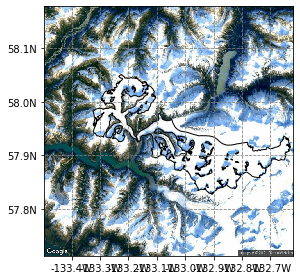

In [23]:
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='rgi-case-2-example', reset=True)
cfg.PARAMS['border'] = 10
gdirs = workflow.init_glacier_directories(['RGI60-01.03890', 'RGI60-01.23664'], from_prepro_level=3, reset=True, force=True)
graphics.plot_googlemap(gdirs);

The upper glacier map is a zoom version of the plot below. 
They share the same glaciers terminus. Therefore, to estimate a calving flux for these glaciers we need them connected. 

### Let's merge these two outlines using geopandas

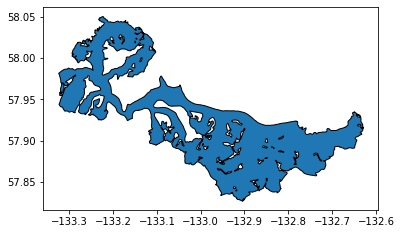

In [24]:
merged = gl.dissolve(by='O2Region', as_index=False) 
merged = merged[gl.columns]
merged.plot(edgecolor='k');

### RGI attributes 

We now have a new shapefile, which resembles an RGI one but has wrong attributes. Some aren't relevant, but some are. See the [documentation](https://oggm.readthedocs.io/en/latest/input-data.html#glacier-outlines-and-intersects) for a list. 

The important ones are: RGIId, CenLon, CenLat, TermType, Area. Area and CenLon, Cenlat can be calculated by OGGM later, as we have seen earlier. Here, we prefer to keep the Area computed by the RGI for consistency.

In [25]:
# We use the RGI as template (this avoids strange IO issues)
template = gl.iloc[[0]].copy()
template['geometry'] = merged['geometry'].values

In [26]:
# Change CenLon, CenLat
cenlon, cenlat = merged.iloc[0].geometry.centroid.xy
template['CenLon'] = cenlon
template['CenLat'] = cenlat

# We sum up the areas
template['Area'] = gl.Area.sum()
template['Area']

3889    275.739
Name: Area, dtype: float64

In [Recinos, et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) we wanted to estimate a frontal ablation flux for this new outline and compare it with previous estimates found in the literature for the Sawyer Glacier ([McNabb et al., 2015](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JF003276)). 

For this reason we kept the Sawyer glacier attributes to the following variables:
`RGIId, GLIMSId, Name`

The `TermType` should be equal to 1, for Marine-terminating. 

In [27]:
template['TermType'] = 1
template['Name'] = 'Sawyer Glacier merged with RGI60-01.23664'

Now we can write a new shapefile for this glacier. 
We recommend doing this if you have to make several model runs. You can also integrate this outline to your main RGI shapefile:

In [28]:
cfg.initialize()
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='rgi-case-2', reset=True)
template.crs = salem.wgs84.srs
template.to_file(os.path.join(cfg.PATHS['working_dir'], 'merged.shp'))

2021-02-03 13:51:42: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:51:42: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:51:42: oggm.cfg: Multiprocessing: using all available processors (N=8)


### Run OGGM with this new glacier

For simplicity, we do not compute the intersects in this case: **however, we recommend you do do so (see above). In all cases, do not use the intersects provided automatically with OGGM when using custom inventories, as they are likely to be wrong.**

In [29]:
# Set-up the run
cfg.PARAMS['border'] = 10

# We don't use intersects here
cfg.PARAMS['use_intersects'] = False

# We prefer OGGM to use the area we computed ourselves
cfg.PARAMS['use_rgi_area'] = True

# Use our merged file
rgidf = gpd.read_file(os.path.join(cfg.PATHS['working_dir'], 'merged.shp'))
gdirs = workflow.init_glacier_directories(rgidf, reset=True, force=True)
gdirs

2021-02-03 13:51:42: oggm.cfg: PARAMS['border'] changed from `20` to `10`.
2021-02-03 13:51:42: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2021-02-03 13:51:42: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


[<oggm.GlacierDirectory>
   RGI id: RGI60-01.03890
   Region: 01: Alaska
   Subregion: 01-06: N Coast Ranges                  
   Name: Sawyer Glacier Merged With Rgi60-01.23664
   Glacier type: Glacier
   Terminus type: Marine-terminating
   Area: 275.739 km2
   Lon, Lat: (-132.99462279101698, 57.92395858254873)]

2021-02-03 13:51:44: oggm.core.gis: (RGI60-01.03890) define_glacier_region
2021-02-03 13:51:46: oggm.core.gis: (RGI60-01.03890) glacier_masks
2021-02-03 13:51:46: oggm.core.gis: (RGI60-01.03890) process_dem
2021-02-03 13:51:47: oggm.core.centerlines: (RGI60-01.03890) compute_centerlines
2021-02-03 13:51:48: oggm.core.centerlines: (RGI60-01.03890) initialize_flowlines
2021-02-03 13:51:48: oggm.core.centerlines: (RGI60-01.03890) catchment_area
2021-02-03 13:51:54: oggm.core.centerlines: (RGI60-01.03890) catchment_width_geom
2021-02-03 13:51:55: oggm.core.centerlines: (RGI60-01.03890) catchment_width_correction
2021-02-03 13:51:56: oggm.core.centerlines: (RGI60-01.03890) chosen binsize 315


Here we are not able to use the [Pre-processed directories](https://docs.oggm.org/en/latest/input-data.html#pre-processed-directories) and the respective [Processing levels](https://docs.oggm.org/en/latest/input-data.html#preprodir) that OGGM provides for a easy run set up. We can't use this workflow simply because we have a different beguinning than OGGM, we have a different RGI! We just need to type more and run all the model task one by one:

In [30]:
from oggm.workflow import execute_entity_task

# Calculate the DEMs and the masks
execute_entity_task(tasks.define_glacier_region, gdirs)
execute_entity_task(tasks.glacier_masks, gdirs)

# Calculate the Pre-processing tasks
task_list = [
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.catchment_area,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
]

for task in task_list:
    execute_entity_task(task, gdirs)

2021-02-03 13:51:44: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2021-02-03 13:51:46: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2021-02-03 13:51:47: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2021-02-03 13:51:48: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2021-02-03 13:51:48: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2021-02-03 13:51:54: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2021-02-03 13:51:55: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers


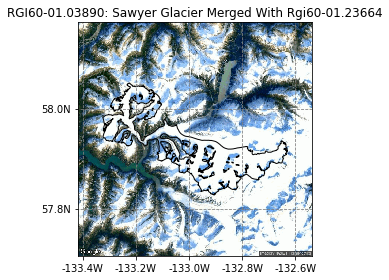

In [31]:
graphics.plot_googlemap(gdirs);

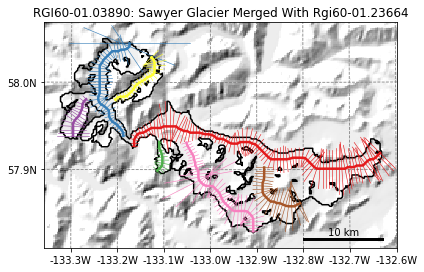

In [32]:
graphics.plot_catchment_width(gdirs, corrected=True);

<a id='case3'></a>
## Case 3: start from a completely independent inventory

Refer to [Case 1](#case1) above, where we show how to start from an RGI template. The main message is: get the attributes right and let OGGM compute the area! 

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)